## Survey data of COVID case fatality rate by state

- Raw data sourced from COVID Tracking Project

### Terms of use

- The COVID Tracking Project at The Atlantic’s data and website content is published under a Creative Commons CC BY 4.0 license, which requires users to attribute the source and license type (CC BY 4.0) when sharing our data or website content.

### Citation

- [the COVID Tracking Project](https://www.covidtrackingproject.com), Creative Commons CC BY 4.0 license

In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load in the COVID Tracking Project dataset by date and by state for US
covidtracking = pd.read_csv("https://api.covidtracking.com/v1/states/daily.csv")

In [3]:
covidtracking.columns

Index(['date', 'state', 'positive', 'probableCases', 'negative', 'pending',
       'totalTestResultsSource', 'totalTestResults', 'hospitalizedCurrently',
       'hospitalizedCumulative', 'inIcuCurrently', 'inIcuCumulative',
       'onVentilatorCurrently', 'onVentilatorCumulative', 'recovered',
       'dataQualityGrade', 'lastUpdateEt', 'dateModified', 'checkTimeEt',
       'death', 'hospitalized', 'dateChecked', 'totalTestsViral',
       'positiveTestsViral', 'negativeTestsViral', 'positiveCasesViral',
       'deathConfirmed', 'deathProbable', 'totalTestEncountersViral',
       'totalTestsPeopleViral', 'totalTestsAntibody', 'positiveTestsAntibody',
       'negativeTestsAntibody', 'totalTestsPeopleAntibody',
       'positiveTestsPeopleAntibody', 'negativeTestsPeopleAntibody',
       'totalTestsPeopleAntigen', 'positiveTestsPeopleAntigen',
       'totalTestsAntigen', 'positiveTestsAntigen', 'fips', 'positiveIncrease',
       'negativeIncrease', 'total', 'totalTestResultsIncrease', 'posNe

In [4]:
df_ctp = covidtracking[['date', 'state', 'fips','positiveIncrease', 'deathIncrease']]
df_ctp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12645 entries, 0 to 12644
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   date              12645 non-null  int64 
 1   state             12645 non-null  object
 2   fips              12645 non-null  int64 
 3   positiveIncrease  12645 non-null  int64 
 4   deathIncrease     12645 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 494.1+ KB


In [5]:
df_ctp['date'] = pd.to_datetime(df_ctp['date'], format='%Y%m%d')

In [6]:
df_ctp.state.unique()

array(['AK', 'AL', 'AR', 'AS', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL',
       'GA', 'GU', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA',
       'MD', 'ME', 'MI', 'MN', 'MO', 'MP', 'MS', 'MT', 'NC', 'ND', 'NE',
       'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI',
       'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VI', 'VT', 'WA', 'WI', 'WV',
       'WY'], dtype=object)

In [7]:
st_population = pd.read_csv('data/state_abbrev.csv', thousands=',') # Load in state population counts and merge with ctp data
df_ctp = df_ctp.merge(st_population, how='inner' ,left_on='state', right_on='Code')
df_ctp.isna().sum() # No missing values!

date                0
state               0
fips                0
positiveIncrease    0
deathIncrease       0
State               0
Code                0
Population          0
CVD_group           0
dtype: int64

In [8]:
grouped_cvd = df_ctp.groupby(['CVD_group', 'date']).sum().reset_index()
grouped_cvd = grouped_cvd.drop('Population', axis=1)

In [9]:
group_population = st_population.groupby('CVD_group').sum().reset_index()
grouped_cvd = grouped_cvd.merge(group_population, on='CVD_group')
grouped_cvd['CVD_group'] = grouped_cvd['CVD_group'].apply(lambda x: 'No outbreak' if x == 0 else x)
grouped_cvd['CVD_group'] = grouped_cvd['CVD_group'].apply(lambda x: 'Spring outbreak' if x == 1 else x)
grouped_cvd['CVD_group'] = grouped_cvd['CVD_group'].apply(lambda x: 'Summer outbreak' if x == 2 else x)
grouped_cvd['CVD_group'] = grouped_cvd['CVD_group'].apply(lambda x: 'Fall outbreak' if x == 3 else x)

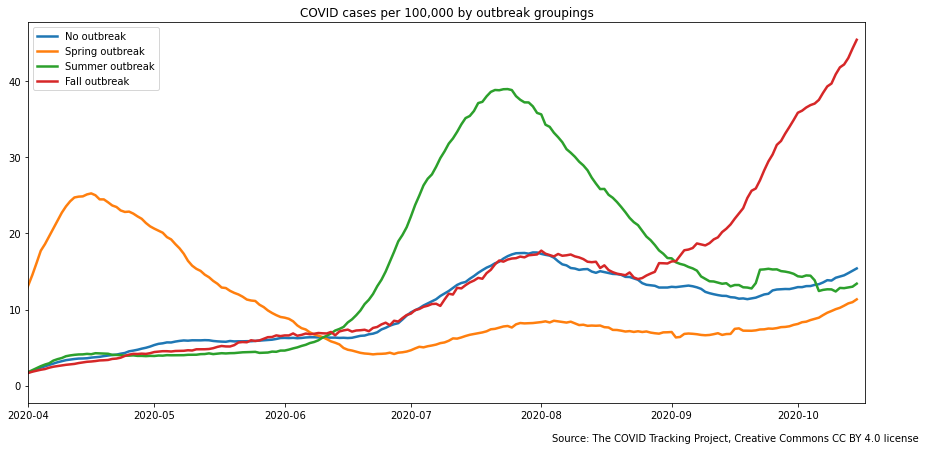

In [33]:
# Cases per 100,000 by group over time
fig, ax = plt.subplots(figsize = (15,7))
plt.figtext(0.95, 0.05, 'Source: The COVID Tracking Project, Creative Commons CC BY 4.0 license', horizontalalignment='right')

for chart_group in grouped_cvd['CVD_group'].unique():
    group_df = grouped_cvd[grouped_cvd['CVD_group']== chart_group]
    group_df['case_SMA'] = group_df.iloc[:,3].rolling(window=14).mean()
    ax.plot(group_df['date'], group_df['case_SMA'] / group_df['Population'] * 100000, label = chart_group, lw=2.5)
    ax.set_xlim([datetime.date(2020, 4, 1), datetime.date(2020, 10, 17)])
    ax.set_title(f'COVID cases per 100,000 by outbreak groupings')
    ax.legend()
plt.savefig('img/COVID-cases-by-outbreak-groupings.png')

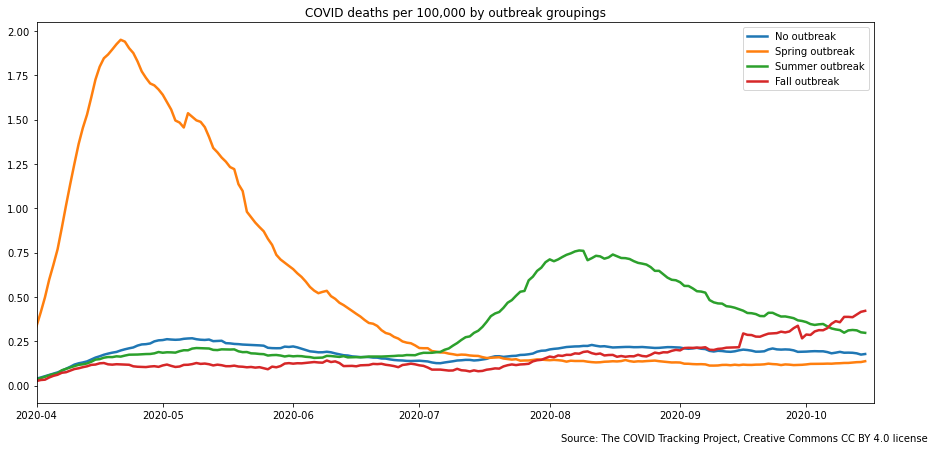

In [34]:
# Deaths per 100,000 by group over time
fig, ax = plt.subplots(figsize = (15,7))
plt.figtext(0.95, 0.05, 'Source: The COVID Tracking Project, Creative Commons CC BY 4.0 license', horizontalalignment='right')

for chart_group in grouped_cvd['CVD_group'].unique():
    group_df = grouped_cvd[grouped_cvd['CVD_group']== chart_group]
    group_df['death_SMA'] = group_df.iloc[:,4].rolling(window=14).mean()
    temp_group_df = group_df[['date', 'death_SMA']]
#     temp_group_df['date'] = temp_group_df['date'] - timedelta(days=14)
    group_df = group_df.merge(temp_group_df, on='date')
    ax.plot(group_df['date'], group_df['death_SMA_y'] / group_df['Population'] * 100000, label = chart_group, lw=2.5)
    ax.set_xlim([datetime.date(2020, 4, 1), datetime.date(2020, 10, 17)])
    ax.set_title(f'COVID deaths per 100,000 by outbreak groupings')
    ax.legend()
plt.savefig('img/COVID-deaths-by-outbreak-groupings.png')

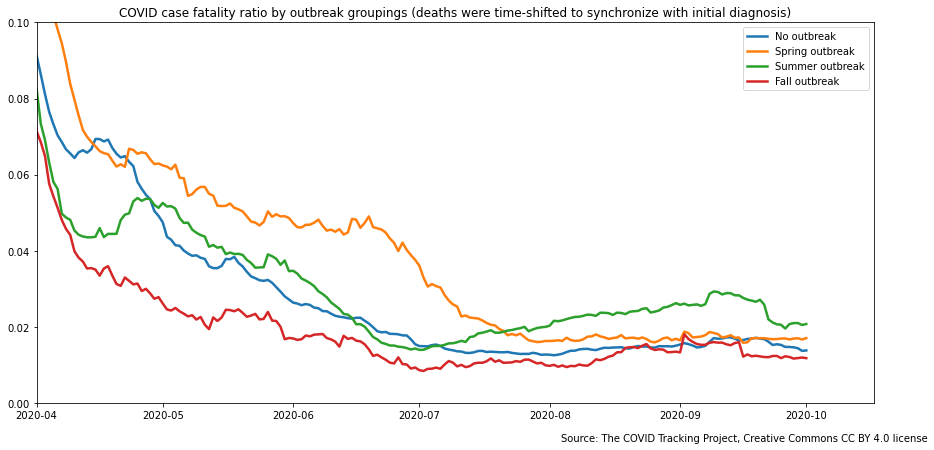

In [35]:
# Case fatality ratio by outbreak group over time
fig, ax = plt.subplots(figsize = (15,7))
plt.figtext(0.95, 0.05, 'Source: The COVID Tracking Project, Creative Commons CC BY 4.0 license', horizontalalignment='right')
    
for chart_group in grouped_cvd['CVD_group'].unique():
    group_df = grouped_cvd[grouped_cvd['CVD_group']== chart_group]
    group_df['case_SMA'] = group_df.iloc[:,3].rolling(window=14).mean()
    group_df['death_SMA'] = group_df.iloc[:,4].rolling(window=14).mean()
    temp_group_df = group_df[['date', 'death_SMA']]
    temp_group_df['date'] = temp_group_df['date'] - timedelta(days=14)
    group_df = group_df.merge(temp_group_df, on='date')
#     print(group_df.head())
    ax.plot(group_df['date'], group_df['death_SMA_y'] / group_df['case_SMA'], label = chart_group, lw=2.5)
    ax.set_xlim([datetime.date(2020, 4, 1), datetime.date(2020, 10, 17)])
    ax.set_ylim(0, 0.1)
    ax.set_title(f'COVID case fatality ratio by outbreak groupings (deaths were time-shifted to synchronize with initial diagnosis)')
    ax.legend()
plt.savefig('img/COVID-case-fatality-by-outbreak-groupings.png')

In [28]:
first, last = (0,20)

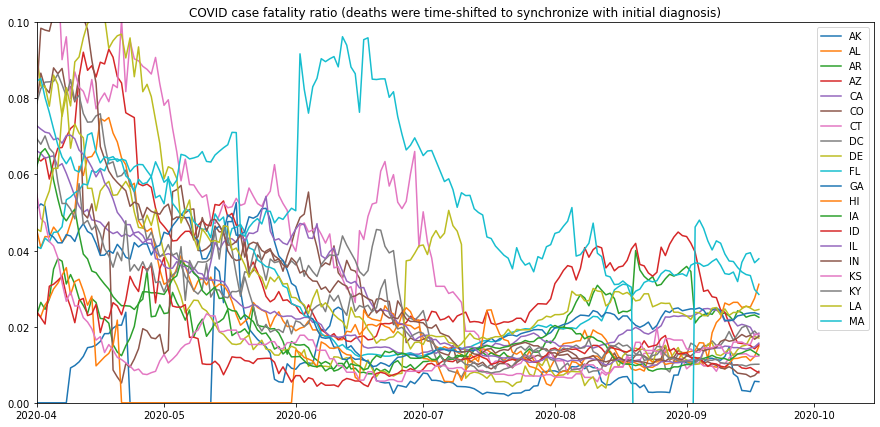

In [29]:
# Case fatality ratio by state over time
fig, ax = plt.subplots(figsize = (15,7))
    
for chart_state in df_ctp['state'].unique()[first:last]:
    state_df = df_ctp[df_ctp['state']== chart_state]
    state_df['case_SMA'] = state_df.iloc[:,3].rolling(window=14).mean()
    state_df['death_SMA'] = state_df.iloc[:,4].rolling(window=14).mean()
    temp_state_df = state_df[['date', 'death_SMA']]
    temp_state_df['date'] = temp_state_df['date'] - timedelta(days=14)
    state_df = state_df.merge(temp_state_df, on='date')
    ax.plot(state_df['date'], state_df['death_SMA_y'] / state_df['case_SMA'], label = chart_state)
    ax.set_xlim([datetime.date(2020, 4, 1), datetime.date(2020, 10, 15)])
    ax.set_ylim(0, 0.1)
    ax.set_title(f'COVID case fatality ratio (deaths were time-shifted to synchronize with initial diagnosis)')
    ax.legend()

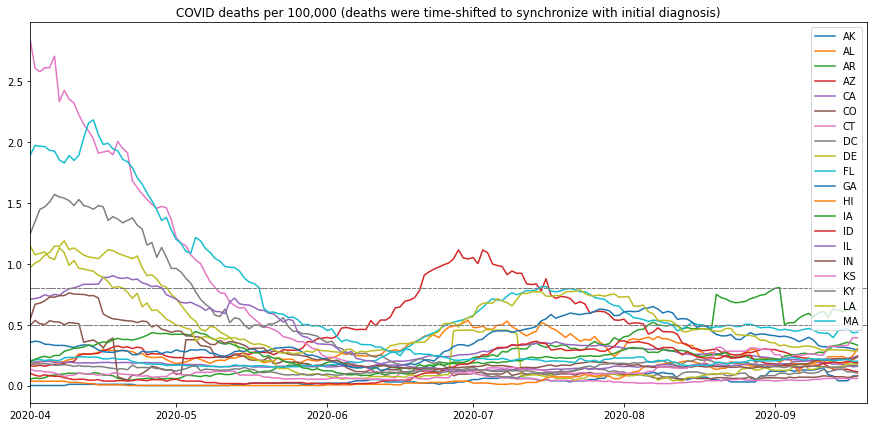

In [30]:
# Deaths per 100,000 by state over time
fig, ax = plt.subplots(figsize = (15,7))
    
for chart_state in df_ctp['state'].unique()[first:last]:
    state_df = df_ctp[df_ctp['state']== chart_state]
    state_df['death_SMA'] = state_df.iloc[:,4].rolling(window=14).mean()
    temp_state_df = state_df[['date', 'death_SMA']]
    temp_state_df['date'] = temp_state_df['date'] - timedelta(days=14)
    state_df = state_df.merge(temp_state_df, on='date')
    ax.plot(state_df['date'], state_df['death_SMA_y'] / state_df['Population'] * 100000, label = chart_state)
    ax.axhline(y=0.8, ls= '--', lw=1, color = 'gray')
    ax.axhline(y=0.5, ls= '--', lw=1, color = 'gray')
    ax.set_xlim([datetime.date(2020, 4, 1), datetime.date(2020, 9, 20)])
    ax.set_title(f'COVID deaths per 100,000 (deaths were time-shifted to synchronize with initial diagnosis)')
    ax.legend()

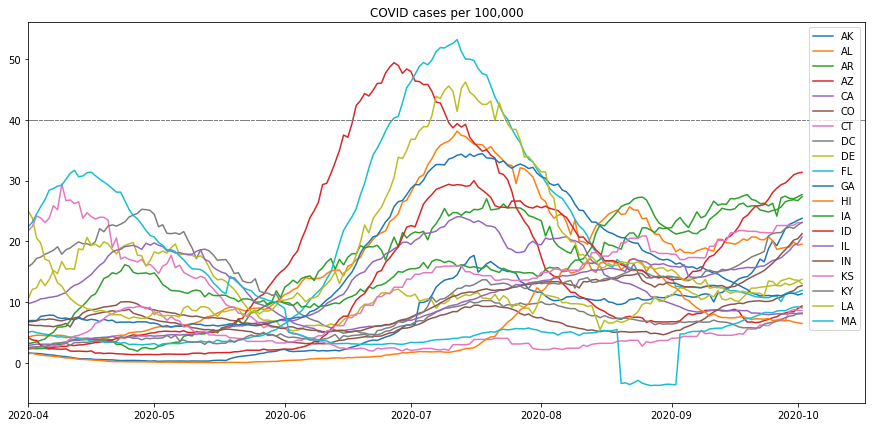

In [31]:
# Cases per 100,000 by state over time
fig, ax = plt.subplots(figsize = (15,7))
    
for chart_state in df_ctp['state'].unique()[first:last]:
    state_df = df_ctp[df_ctp['state']== chart_state]
    state_df['case_SMA'] = state_df.iloc[:,3].rolling(window=14).mean()
    ax.plot(state_df['date'], state_df['case_SMA'] / state_df['Population'] * 100000, label = chart_state)
    ax.set_xlim([datetime.date(2020, 4, 1), datetime.date(2020, 10, 17)])
    ax.set_title(f'COVID cases per 100,000')
    ax.axhline(y=40, ls= '--', lw=1, color = 'gray')
    ax.legend()

In [27]:
chart_state = 'TN'
state_df = df_ctp[df_ctp['state']== chart_state]
state_df['case_SMA'] = state_df.iloc[:,3].rolling(window=14).mean()
state_df['death_SMA'] = state_df.iloc[:,4].rolling(window=14).mean()
temp_state_df = state_df[['date', 'death_SMA']]
temp_state_df['date'] = temp_state_df['date'] - timedelta(days=14)
state_df = state_df.merge(temp_state_df, on='date')

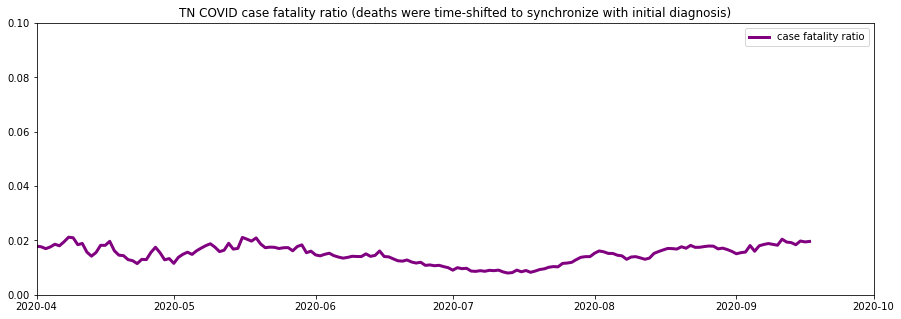

In [488]:
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(state_df['date'], state_df['death_SMA_y'] / state_df['case_SMA'], label = 'case fatality ratio', color = 'purple', lw=3)
ax.set_xlim([datetime.date(2020, 4, 1), datetime.date(2020, 10, 15)])
ax.set_ylim(0, 0.1)
ax.set_title(f'{chart_state} COVID case fatality ratio (deaths were time-shifted to synchronize with initial diagnosis)')
ax.legend()

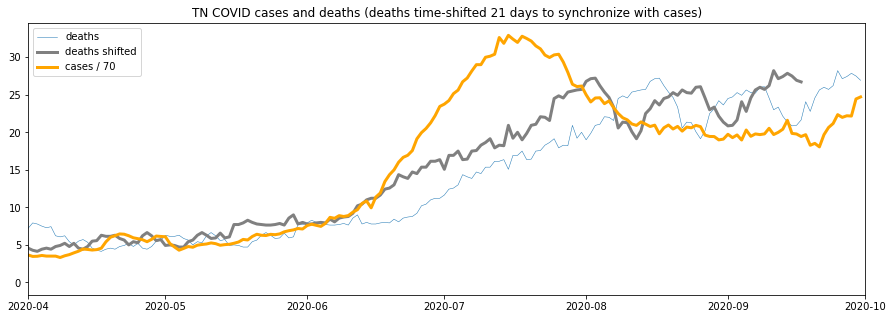

In [489]:
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(state_df['date'], state_df['death_SMA_x'], label = 'deaths', lw= .5)
ax.plot(state_df['date'], state_df['death_SMA_y'], label = 'deaths shifted', color = 'gray', lw=3)
ax.plot(state_df['date'], state_df['case_SMA'] / 70, label = 'cases / 70', color = 'orange', lw=3)
ax.set_xlim([datetime.date(2020, 4, 1), datetime.date(2020, 10, 15)])
ax.set_title(f'{chart_state} COVID cases and deaths (deaths time-shifted 21 days to synchronize with cases)')
ax.legend()